In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [10]:
i = 30
y, I = np.genfromtxt(f'SEMSANS_Delft/{i}/det.dat', delimiter=' ', usecols=(0,1), unpack=True)
_, I_base = np.genfromtxt(f'SEMSANS_Delft_no_sample/{i}/det.dat', delimiter=' ', usecols=(0,1), unpack=True)
_, I_flat = np.genfromtxt(f'SEMSANS_Delft_no_sample_no_analyzer/{i}/det.dat', delimiter=' ', usecols=(0,1), unpack=True)
_, I_unpolarized = np.genfromtxt(f'SEMSANS_Delft_no_sample_unpolarized/{i}/det.dat', delimiter=' ', usecols=(0,1), unpack=True)


y*=1e-2

plt.plot(y*1e3, I,'-',  label='Sample, analyzer')
plt.plot(y*1e3, I_base, label='No sample, analyzer')
plt.plot(y*1e3, I_flat, label='No sample, no analyzer')
plt.plot(y*1e3, I_unpolarized, label='No sample, unpolarized')

plt.xlabel('y [mm]')
plt.ylabel('I')
plt.title('PSD intensity')
plt.grid(True)  # Add grid
plt.legend()
plt.show()

FileNotFoundError: SEMSANS_Delft/30/det.dat not found.

In [5]:
from definitions import *

compute_By(6.65e-6)

0.04634699955537887

In [6]:
max_By = compute_By(3e-6)
round(max_By, 6)

0.020908

In [7]:
def indices_within_range(x, a, b):
    return np.where((x >= a) & (x <= b))[0]

# def I_fit(y, a, b, p_inv):
#     return (a + b * np.cos(2*np.pi * y * p_inv))

# def I_fit_2(y, a, b, p_inv, d):
#     return (a + b * np.cos(2*np.pi * y * p_inv) * np.exp(-d * y**2))


# def I_mod(y, I_0, A, p_0):
#     return I_0 * (1 + A * np.cos(2*np.pi * y / p_0))

# def I_mod_2(y, I_0, A, p_0,d):
#     return I_0 * (1 + A * np.cos(2*np.pi * y / p_0) * np.exp(-d * y**2))

def fit_pattern(y, I, I_unpol, By, plot=False):
    p_0_pred = compute_p_0(By)
    p_inv = 1/p_0_pred
    indices = indices_within_range(y, -0.0005, 0.0005)

    # The DC component can be expected to be the mean
    mean = np.mean(I[indices])
    # The amplitude will be roughly the max minus the mean
    amplitude = (np.max(I[indices]) - mean)/mean

    # bounds = ([0.7 * mean, 0.7 * amplitude, 0.8*p_inv,0.0], [1.3 * mean, 1.3 * amplitude, 1.2*p_inv,2*np.pi])
    guess =  [amplitude, p_inv]
    def I_fit(y,A, p_inv):
        return I_unpol[indices] * (1 + A * np.cos(2*np.pi * y * p_inv))
    popt, pcov = curve_fit(I_fit, y[indices], I[indices],p0=guess)
    diag = np.diagonal(pcov)

    A_0 = popt[0]
    dA_0 = diag[0]
    p_0_fit = 1/popt[1]
    dp_0_fit = diag[1] / popt[1]**2
    if plot:    
        I_fitted = I_fit(y[indices],*popt)
        I_guess = I_fit(y[indices],*[amplitude, p_inv])
        plt.plot(y*1e3, I, '.', label='Simulation data')
        plt.plot(y[indices]*1e3, I_fitted, label='Fit')
        # plt.plot(y[indices]*1e3, I_guess, label='Guess')
        plt.xlabel('y [mm]')
        plt.ylabel('I')
        plt.grid(True)
        plt.legend()
        plt.show()
    return [A_0,p_0_fit], [dA_0,dp_0_fit]

def V_direct(y, I, min_y, max_y):
    indices = indices_within_range(y, min_y, max_y)
    I_max = np.max(I[indices])
    I_min = np.min(I[indices])
    print(I_max, I_min)
    V = (I_max - I_min) / (I_max + I_min)
    print(V)
    return V

/home/tbvanderwoude/repos/bep/definitions.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  p_0 = np.pi * np.tan(theta_0) / (c * wavelength * delta_B)
/tmp/ipykernel_61250/1742741442.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(I_fit, y[indices], I[indices],p0=guess)
/tmp/ipykernel_61250/1742741442.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  p_0_fit = 1/popt[1]


0.0 inf
0.00156 0.0019344756899439997
0.00312 0.0009672378449719998
0.00468 0.0006448252299813332
0.00624 0.0004836189224859999
0.0078 0.00038689513798879997
0.00936 0.0003224126149906666
0.01092 0.000276353669992
0.01248 0.00024180946124299996
0.01404 0.00021494174332711106
0.0156 0.00019344756899439998
0.01716 0.0001758614263585454
0.01872 0.0001612063074953333
0.02028 0.00014880582230338457
0.02184 0.000138176834996
0.0234 0.00012896504599626665
0.02496 0.00012090473062149998
0.02652 0.0001137926876437647
0.02808 0.00010747087166355553
0.02964 0.00010181450999705262
0.0312 9.672378449719999e-05
0.03276 9.21178899973333e-05
0.03432 8.79307131792727e-05
0.03588 8.410763869321737e-05
0.03744 8.060315374766664e-05
0.039 7.737902759775998e-05
0.04056 7.440291115169229e-05
0.04212 7.164724777570368e-05
0.04368 6.9088417498e-05
0.04524 6.6706058273931e-05
0.0468 6.448252299813332e-05
Data saved successfully.


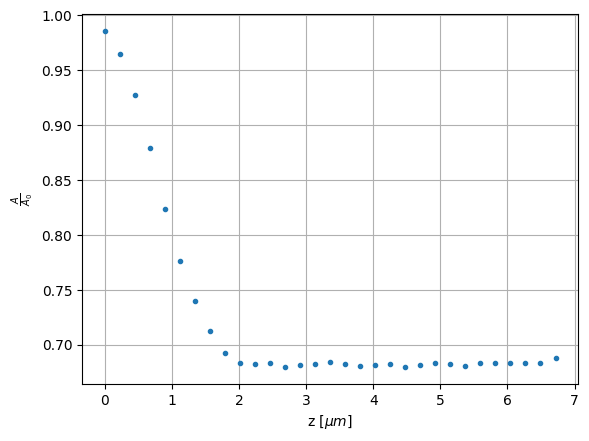

In [9]:
import re

def extract_By(file):
    with open(file) as f:
        text = f.read()
        match = re.search(r'# Param: By=([0-9.]+)', text)
        assert(match)
        return float(match.group(1))

N = 31
R = np.zeros((N))
dR = np.zeros((N))
z = np.zeros((N))
for i in range(0,N):
    By = extract_By(f"SEMSANS_Delft/{i}/det.dat")
    print(By, compute_p_0(By))
    y, I = np.genfromtxt(f"SEMSANS_Delft/{i}/det.dat", delimiter=' ', usecols=(0,1), unpack=True)
    _, I_base = np.genfromtxt(f"SEMSANS_Delft_no_sample/{i}/det.dat", delimiter=' ', usecols=(0,1), unpack=True)
    _, I_unpol = np.genfromtxt(f"SEMSANS_Delft_no_sample_unpolarized/{i}/det.dat", delimiter=' ', usecols=(0,1), unpack=True)
    y *= 1e-2
    params, dparams = fit_pattern(y, I, I_unpol, By, False)
    params_base, dparams_base = fit_pattern(y, I_base, I_unpol, By, False)
    A_z = params[0]
    A_0 = params_base[0]
    # V_z = V_direct(y,I, -0.004, 0.004) 
    # V_0 = V_direct(y,I_base, -0.004, 0.004) 
    z[i] = compute_z(By)
    R[i] = A_z/A_0
    dR[i] = 0.0  
combined_data = np.hstack((z.reshape(-1, 1), R.reshape(-1, 1)))
np.savetxt('simulation-fit.txt', combined_data, delimiter=',')
print("Data saved successfully.")
plt.plot(z * 1e6,R,'.')
plt.xlabel(r'z [$\mu m$]')
plt.ylabel(r'$\frac{A}{A_0}$')
plt.grid(True)